# Pre TP1

In [132]:
#!pip install tenacity


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [240]:
# Para visualización en notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Parámetros de visualización
sns.set_context('talk')
mpl.rcParams['figure.figsize'] = (8, 6)


import os
from collections import Counter

# Números y Datos
import numpy as np
import pandas as pd

import networkx as nx
from networkx.algorithms.approximation import average_clustering

from glob import glob
from pathlib import Path
from tenacity import retry

In [241]:
files = os.listdir('DataSujetos/')
print(len(files)) #72 archivos
print(files)
suj1 = list(Path('DataSujetos').glob('*_suj1.csv'))
print(len(suj1)) #4 estados por sujeto => 18 sujetos
# Comprobemos que no sobre ni falte nada
for i in range(20):
    patron = '*_suj' + str(i) + '.csv'
    suj = list(Path('DataSujetos').glob(patron))
    print(f"Sujeto {str(i)}: Número de archivos: {len(suj)}")

# Conclusión: Sujetos 1 a 18 con cuatro archivos cada uno

72
['N3_suj18.csv', 'N2_suj8.csv', 'N3_suj8.csv', 'N3_suj9.csv', 'N2_suj9.csv', 'W_suj18.csv', 'W_suj1.csv', 'N1_suj10.csv', 'N1_suj7.csv', 'N2_suj18.csv', 'N1_suj6.csv', 'N1_suj11.csv', 'W_suj2.csv', 'N1_suj13.csv', 'N1_suj4.csv', 'N1_suj5.csv', 'N1_suj12.csv', 'W_suj3.csv', 'W_suj7.csv', 'N1_suj1.csv', 'N1_suj16.csv', 'N1_suj17.csv', 'W_suj6.csv', 'W_suj4.csv', 'N1_suj2.csv', 'N1_suj15.csv', 'N1_suj14.csv', 'N1_suj3.csv', 'W_suj5.csv', 'W_suj8.csv', 'N2_suj11.csv', 'N2_suj10.csv', 'N1_suj18.csv', 'W_suj9.csv', 'N2_suj12.csv', 'N2_suj13.csv', 'N1_suj8.csv', 'N2_suj17.csv', 'N2_suj16.csv', 'N1_suj9.csv', 'N2_suj14.csv', 'N2_suj15.csv', 'N3_suj11.csv', 'W_suj17.csv', 'N2_suj2.csv', 'N3_suj2.csv', 'N3_suj3.csv', 'N2_suj3.csv', 'W_suj16.csv', 'N3_suj10.csv', 'N3_suj12.csv', 'W_suj14.csv', 'N3_suj1.csv', 'N2_suj1.csv', 'W_suj15.csv', 'N3_suj13.csv', 'N3_suj17.csv', 'W_suj11.csv', 'N3_suj4.csv', 'N2_suj4.csv', 'N2_suj5.csv', 'N3_suj5.csv', 'W_suj10.csv', 'N3_suj16.csv', 'N3_suj14.csv', 'W_s

In [246]:
# Definición de Funciones
'''
Permite obtener una Matriz de Adyacencia Pesada (MAP) 
a partir de los datos contenidos en el archivo especificado
Substrae una matriz diagonal de 1s para evitar conexiones 
reflexivas (un nodo consigo mismo)
'''
def obtener_map(nombre_archivo):
    df = pd.read_csv(nombre_archivo, header=None)
    matAdyacPesada = df.values
    n = matAdyacPesada.shape[0]
    matAdyacPesada -= np.diag(np.ones(n))
    return matAdyacPesada

'''
Crea un heatmap a partir de una matriz
'''
def graficar_heatmap(matriz, titulo=''):
    sns.heatmap(matriz)
    n = matriz.shape[0]
    plt.xlim(0, n)
    plt.ylim(0, n)
    plt.title(titulo)
    plt.show()

'''
Exporta un archivo de imagen
de un heatmap obtenido a partir de una matriz
'''
def exportar_heatmap(matriz, nombre_archivo='imagen_01.png'):
    sns.heatmap(matriz)
    n = matriz.shape[0]
    plt.xlim(0, n)
    plt.ylim(0, n)
    plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')
    plt.close()

'''
Data una matriz de adyacencia pesada y un valor 
de densidad de enlaces, calcula el valor umbral
necesario para representar valores que estén
por encima de la densidad de enlaces dada
'''
def densidad_a_umbral(matriz, densidad=0.1):
    n = matriz.shape[0]
    tril_idx = np.tril_indices(n, -1)
    c = sorted(np.array(list(matriz[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c)-1)*densidad)]

'''
Permite representar un grafo 
'''
def representar_grafo(G, titulo='', zip_de_layout=None, mostrar_etiquetas=True, nombre_archivo=None):
    plt.figure(figsize=(8, 6))
    plt.title(titulo, fontsize=14)
    nx.draw(G, zip_de_layout, with_labels=mostrar_etiquetas, node_size=25, width=0.1, linewidths=0.25)
    if not nombre_archivo == None:
        plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')
    plt.show()

'''
Permite representar un grafo a partir de una matriz
de Adyacencia - Agrega una escala de colores para los 
nodos, que refleja el grado
Paletas disponibles: plt.cm.{Grays|Blues|BuGn|PuRd|Oranges}
'''
def representar_grafo_escala_colores(G, escala_color='grados', titulo='', zip_de_layout=None, mostrar_etiquetas=False, nombre_archivo=None):
    if escala_color == 'grados':
        valores_escala = dict(G.degree()) 
    elif escala_color == 'clustering':
        valores_escala = nx.clustering(G)
    nodos = G.nodes()
    n = len(list(nodos))
    n_color = np.asarray([valores_escala[n] for n in nodos])
    vmin = min(n_color)
    vmax = max(n_color)
    cmap = plt.cm.Oranges
    norm = plt.Normalize(vmin = vmin, vmax=vmax)
    plt.figure(figsize=(9,6))
    plt.title(titulo, fontsize=14)
    nx.draw(G, zip_de_layout, node_size=25, node_color=n_color, width=0.1, linewidths=0.25, vmin=vmin, vmax=vmax,cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, ax=plt.gca())
    if not nombre_archivo==None:
        plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')
    plt.show()

'''
En Grafos dirigidos, permite obtener la mayor componente altamente conexa
'''
def obtener_mayor_componente_fuertemente_conexa(G): 
    if nx.is_directed(G):
        StronglyCC = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
        return G.subgraph(StronglyCC[0])
    else:
        return None

'''
Calcula el diámetro del Grafo teniendo en cuenta:
    Si la red es no dirigida:
        Si la red es conexa, devuelve el diametro directo
        Si no es conexa devuelve el diámetro de la componente gigante
    Si la red es dirigida:
        Si está fuertemente conectada devuelve el diametro
        Si no está fuertemente conectada, devuelve el diámetro de la mayor componente fuertemente conectada
'''
def calcular_diametro(G):
    if not nx.is_directed(G):
        if nx.is_connected(G):
            print("La red no dirigida y conexa, obteniendo diámetro en forma directa")
            D = nx.diameter(G)
        else:
            print("La red es no dirigida y no es conexa. Retornando el diámetro de la componente gigante.")
            gigante = G.subgraph(max(nx.connected_components(G), key=len)).copy()
            D = nx.diameter(gigante)
    else:
        if nx.is_strongly_connected(G):
            print("La red es dirigida y fuertemente conexa, obteniendo diámetro en forma directa")
            D = nx.diameter(G)
        else:
            largest_scc = max(nx.strongly_connected_components(G), key=len)
            G_scc = G.subgraph(largest_scc).copy()
            print("La red es dirigida y no fuertemente conexa, obteniendo diámetro de la mayor componente fuertemente conexa")
            D = nx.diameter(G_scc)

    return D

'''
Para redes muy grandes, calcula la distancia media por sampleo
tomando n pares de nodos, calculando entre ellos la distancia más
corta y luego promediando.
Utilizo el decorator @retry porque en ciertos ejemplos, uno o más pares de nodos
elegidos pueden no estar conectados y luego su camino no está definido, arrojando 
una excepción. Retry me permite avanzar desestimando el error
'''
@retry
def calcular_distancia_media_y_eff_por_sampleo(G, numero_muestras=100):

    nodos = list(G)
    if numero_muestras > len(nodos):
        numero_muestras = len(nodos)

    if numero_muestras > 100000:
        numero_muestras = 100000
    
    pares = np.random.choice(nodos, (numero_muestras, 2))
    distancias = [nx.shortest_path_length(G, *par)
               for par in pares]
    inversas = [(1/nx.shortest_path_length(G, *par))
               for par in pares]
    return np.mean(distancias), np.mean(inversas)


'''
Devuelve el grado promedio y el nodo con mayor grado
'''
def calcular_grados(matriz, densidad=0.1): 
    G = nx.from_numpy_array(matriz)
    if nx.is_weighted(G):
        umbral = densidad_a_umbral(matriz, densidad)
        G = nx.from_numpy_array(matriz >= umbral)
    else:
        G = nx.from_numpy_array(matriz)
    grados = [G.degree(n) for n in G.nodes()]
    promedio = np.mean(grados)
    nodo_max = max(G.degree(), key=lambda x: x[1])
    return promedio, nodo_max

'''
Analiza y reporta varios parametros de los grafos
'''
def analizar_grafo(G):
    
    print('Es un grafo dirigido?:',nx.is_directed(G))
    print('Es un grafo pesado?:',nx.is_weighted(G))
    if not nx.is_directed(G):
        print('Es un grafo conectado?:',nx.is_connected(G))
    else:
        print('Grafo dirigido no acepta definición de conexo')
    
    diametro = calcular_diametro(G)
    print(f"Diámetro: {diametro}")
    
    if nx.is_directed(G):
        print('Es un grafo fuertemente conexo?:',nx.is_strongly_connected(G))
        print('Es un grafo debilmente conexo?:',nx.is_weakly_connected(G))
        componente_mayor_fuertemente_conexa = obtener_mayor_componente_fuertemente_conexa(G)
        print("Componente mayor fuertemente conexa")
        print(componente_mayor_fuertemente_conexa)
    else:
        print("Por no ser dirigido no acepta determinación de fuertemente o débilmente conexo")
    
    # Cálculo de distancia media
    if nx.is_connected(G):
        distancia_media_directa = nx.average_shortest_path_length(G)
        distancia_media_sampleo, eficiencia_sampleo = calcular_distancia_media_y_eff_por_sampleo(G)
        print(f"Distancia Media del Grafo obtenida por muestreo: {distancia_media_sampleo}")
        print(f"Distancia Media Diecta del Grafo: {distancia_media_directa}")
        print(f"Eficiencia Global Del Grafo obtenida por muestreo: {eficiencia_sampleo}")
    else:
        print("El grafo no es conexo, calculando la distancia media y la eficiencia de la componente gigante")
        print("Esta es una lista de las componentes conexas y su distancia media")
        for componente_nodos in nx.connected_components(G):
            subgrafo = G.subgraph(componente_nodos)
            n = subgrafo.number_of_nodes()
            if nx.is_connected(subgrafo) and n > 1:
                L = nx.average_shortest_path_length(subgrafo)
                print(f"- Componente de {n} nodos con distancia media: {L:.3f}")
            #elif n == 1:
            #    print(f"- Componente aislada de 1 nodo (sin distancia definida)")
        
        gigante = G.subgraph(max(nx.connected_components(G), key=len)).copy()
        distancia_media_directa = nx.average_shortest_path_length(gigante)
        nodos_gigante = gigante.number_of_nodes()
        print(f"La componente Gigante tiene {nodos_gigante} nodos")
        eficiencia_directa = nx.global_efficiency(gigante)
        distancia_media_sampleo, eficiencia_sampleo = calcular_distancia_media_y_eff_por_sampleo(gigante) 
        print(f"Distancia Media  de la Componente Gigante obtenida por muestreo: {distancia_media_sampleo}")
        print(f"Distancia Media Directa de la Componente Gigante: {distancia_media_directa}")
        print(f"Eficiencia Global de la Componente Gigante obtenida por muestreo: {eficiencia_sampleo}")    
        print(f"Eficiencia Global Directa de la Componente Gigante: {eficiencia_directa}")

    
    eficiencia_directa = nx.global_efficiency(G)
    print(f"Eficiencia Global Directa del Grafo: {eficiencia_directa}")
    
    

def graficar_distribucion_grados(G, bins=10, titulo='Distribución de Grados', nombre_archivo=None):
    plt.figure(figsize=(6, 4))
    grados = [G.degree(n) for n in G.nodes()]
    hist, bins, _ = plt.hist(grados, bins=bins, density=True)
    plt.xlabel('k')
    plt.ylabel('p(k)')
    plt.title(titulo)
    if not nombre_archivo == None:
        plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')
    plt.show()

def graficar_distribucion_grados_normalizada(G, bins=10, titulo='Distribución de Grado Normalizada', nombre_archivo=None):
    grados = [G.degree(n) for n in G.nodes()]
    conteo = Counter(grados)
    total_nodos = G.number_of_nodes()
    
    # Crear distribución normalizada
    grados_k = sorted(conteo.keys())
    pk = [conteo[k] / total_nodos for k in grados_k]

    # Graficar
    plt.figure(figsize=(6, 4))
    plt.bar(grados_k, pk, width=0.8, color='skyblue', edgecolor='black')
    #plt.hist(grados_k, bins=bins, density=True)
    plt.xlabel('Grado k')
    plt.ylabel('p(k)')
    plt.title(titulo)
    
    if nombre_archivo:
        plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')
    
    plt.show()



# Instrucciones
Las celdas de arriba hay que ejecutarlas siempre, pero a partir de aquí cada celda es independiente
y funciona por sí sola. No es necesario ejecutar toda la secuencia para que cada celda funcione.

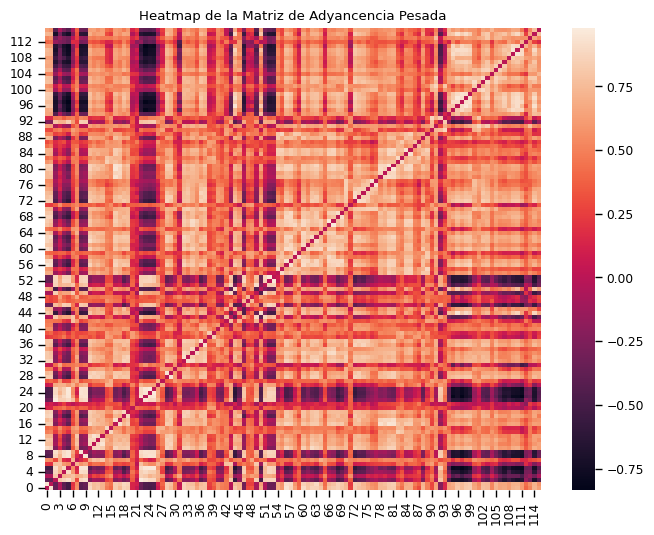

In [50]:
# Sujeto 2 - Condición de Vigilia
matriz = obtener_map('DataSujetos/W_suj2.csv')
plot = graficar_heatmap(matriz, "Heatmap de la Matriz de Adyancencia Pesada")
exportar_heatmap(matriz, nombre_archivo='W_suj2-pesada_heatmap.png')

El umbral obtenido para una densidad de enlaces de 0.08 es: 0.77997


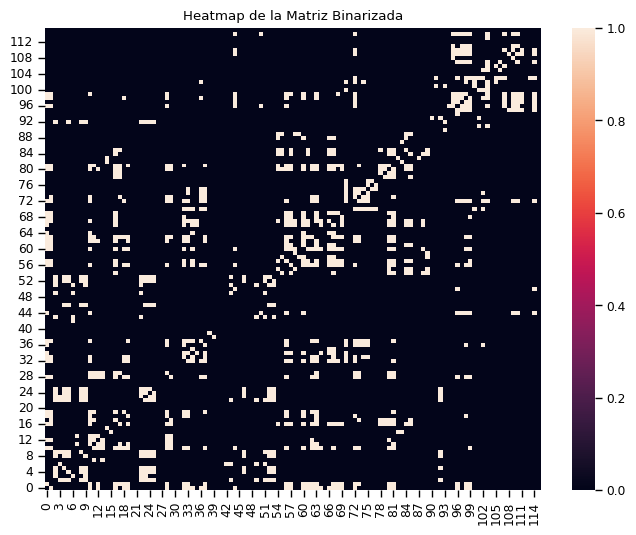

In [32]:
# Sujeto 2 - Condición de Vigilia, matriz binarizada
# Vamos a pedir una densidad de enlaces de 0.08

matriz = obtener_map('DataSujetos/W_suj2.csv')
densidad = 0.08
umbral = densidad_a_umbral(matriz, densidad)
print(f"El umbral obtenido para una densidad de enlaces de {densidad} es: {umbral}")

matriz_binarizada = matriz >= umbral
graficar_heatmap(matriz_binarizada, "Heatmap de la Matriz Binarizada")
exportar_heatmap(matriz_binarizada, 'W_suj2-binarizada_heatmap.png')

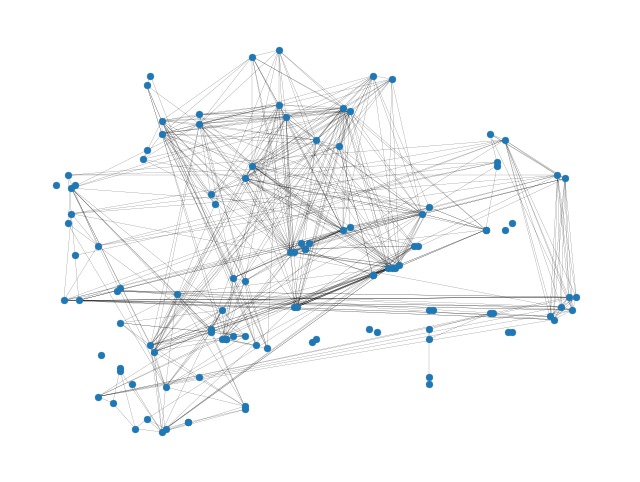

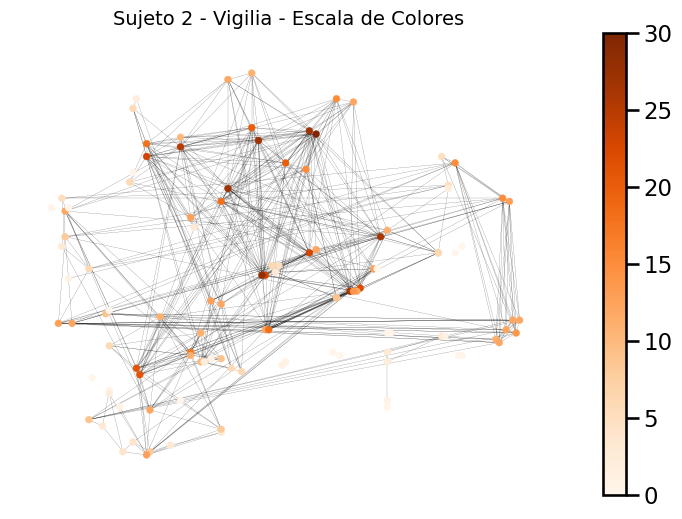

In [199]:
# Sujeto 2 - Condición de Vigilia - Representar Grafo
matriz = obtener_map('DataSujetos/W_suj2.csv')
G = nx.from_numpy_array(matriz >= 0.7797)
regiones = pd.read_csv("aal_extended_withCoords.csv", header=None).iloc[:,1:]
n = matriz.shape[0]
layout = dict(zip(range(n),np.array([regiones[6].values, regiones[7].values]).T))
representar_grafo(G, titulo="", zip_de_layout=layout, mostrar_etiquetas=False, nombre_archivo="Figura_02.png")

representar_grafo_escala_colores(G, titulo="Sujeto 2 - Vigilia - Escala de Colores", zip_de_layout=layout)


In [224]:
# Analizar el Grafo
matriz = obtener_map('DataSujetos/W_suj2.csv')
G = nx.from_numpy_array(matriz >= 0.7797)
analizar_grafo(G)


Es un grafo dirigido?: False
Es un grafo pesado?: True
Es un grafo conectado?: False
La red es no dirigida y no es conexa. Retornando el diámetro de la componente gigante.
Diámetro: 11
Por no ser dirigido no acepta determinación de fuertemente o débilmente conexo
El grafo no es conexo, calculando la distancia media y la eficiencia de la componente gigante
Esta es una lista de las componentes conexas y su distancia media
- Componente de 92 nodos con distancia media: 3.891
- Componente de 5 nodos con distancia media: 1.600
- Componente de 2 nodos con distancia media: 1.000
La componente Gigante tiene 92 nodos
Distancia Media  de la Componente Gigante obtenida por muestreo: 3.760869565217391
Distancia Media Directa de la Componente Gigante: 3.891304347826087
Eficiencia Global de la Componente Gigante obtenida por muestreo: 0.40402001380262254
Eficiencia Global Directa de la Componente Gigante: 0.3882624190854064
Eficiencia Global Directa del Grafo: 0.24491751418663338


In [150]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

def read_graph_weighted(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_weighted_edges_from(array)
    return G

def read_dir_graph(filename):
    G = nx.DiGraph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

def read_dir_graph_weighted(filename):
    G = nx.DiGraph()
    array = np.loadtxt(filename, dtype=int)
    G.add_weighted_edges_from(array)
    return G

air = read_dir_graph_weighted('TP1/airport.txt')
analizar_grafo(air)

Es un grafo dirigido?: True
Es un grafo pesado?: True
Grafo dirigido no acepta definición de conexo
La red es dirigida y no fuertemente conexa, obteniendo diámetro de la mayor componente fuertemente conexa
Diámetro: 9
Es un grafo dirigido?: True
Es un grafo fuertemente conexo?: False
Es un grafo debilmente conexo?: False
Componente mayor fuertemente conexa
DiGraph with 1402 nodes and 28032 edges
Distancia Media: 3.2
Eficiencia Global: 0.34333333333333343


In [225]:
# Cálculo de Grados
matriz = obtener_map('DataSujetos/W_suj2.csv')
matriz_binarizada = matriz >= densidad_a_umbral(matriz, 0.08)
promedio, nodo_max = calcular_grados(matriz, densidad=0.08)

print(f"El grado promedio de la red es: {promedio}")
print(f"El nodo de mayor grado es: {nodo_max[0]}, y su grado es: {nodo_max[1]}")


El grado promedio de la red es: 9.206896551724139
El nodo de mayor grado es: 0, y su grado es: 30


In [231]:
# Calculo del Coeficiente de Clustering
matriz = obtener_map('DataSujetos/W_suj2.csv')
G = nx.from_numpy_array(matriz >= densidad_a_umbral(matriz, 0.08))
coef_medio_clustering = average_clustering(G, trials=1000)
print(f"El Coeficiente de Clustering medio es: {coef_medio_clustering}")

El Coeficiente de Clustering medio es: 0.544


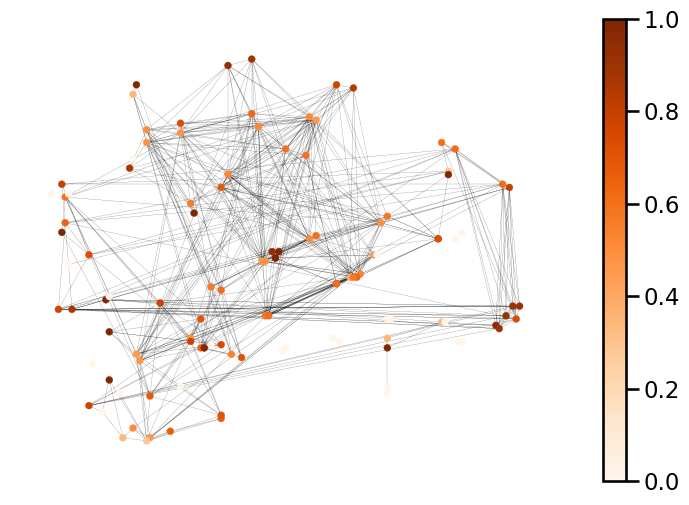

In [235]:
# Gráfico En escala de colores de acuerdo al clustering
matriz = obtener_map('DataSujetos/W_suj2.csv')
G = nx.from_numpy_array(matriz >= densidad_a_umbral(matriz, 0.08))
representar_grafo_escala_colores(G, escala_color='clustering', titulo="", zip_de_layout=layout, nombre_archivo='Figura_04.png')


# air = read_dir_graph_weighted('TP1/airport.txt')
# representar_grafo_escala_colores(air, escala_color='clustering', titulo="Sujeto 2 - Vigilia - Escala de Colores por Clustering", zip_de_layout=None)


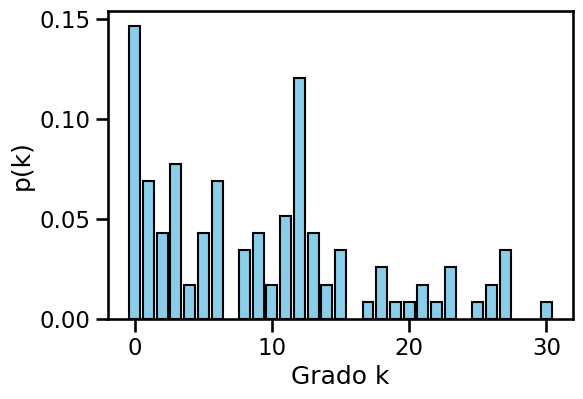

In [247]:
# Representar histograma de Distribución de Grados
matriz = obtener_map('DataSujetos/W_suj2.csv')
umbral = densidad_a_umbral(matriz, 0.08)
G = nx.from_numpy_array(matriz >= umbral)
# Usando Regla de Friedman Diaconis y sabiendo que el máximo es 30, tomo 15 bins, con un ancho de bin = 2
#graficar_distribucion_grados(G, bins=18, titulo='', nombre_archivo='Figura_03.png')
graficar_distribucion_grados_normalizada(G, bins=18, titulo='', nombre_archivo='Figura_03.png')
